# Part 2 - GRU

## Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [2]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)


## Load vector embedding models

### Word2Vec


In [3]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [4]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector


### Fasttext

In [5]:
# fasttextmodel = FastText()
fasttext_file = '../.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [6]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index

# label_dict_NER['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1

output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'CASE_NUMBER': 0,
 'COURT': 1,
 'DATE': 2,
 'GPE': 3,
 'JUDGE': 4,
 'ORG': 5,
 'OTHER_PERSON': 6,
 'PETITIONER': 7,
 'PRECEDENT': 8,
 'PROVISION': 9,
 'RESPONDENT': 10,
 'STATUTE': 11,
 'WITNESS': 12,
 'O': 13}

### Create list of unique labels - LR

In [7]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'B': 0, 'I': 1, 'O': 2}

### Verifying LR_train

In [8]:
# id = 0
# for entry in LR_train:
#     if (len(entry['text'].split()) != len(entry['labels'])):
#         print(entry['id'])
#         print(len(entry['text'].split()))
#         print(len(entry['labels']))

### Define NER dataset class

In [9]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"
        # self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [10]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Training Loop

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores
        

### Modified NN models

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.sequential_model = base_model
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, len(label_dict))
        self.relu = nn.ReLU()

    def forward(self, x):
        x, hn = self.sequential_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x, hn

## Word2Vec Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [34]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "word2vec", padding=True), batch_size=64, shuffle=True)

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [35]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "word2vec", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [36]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [37]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_gru_word2vec.pt")

Epoch 1
Train loss: 0.3348748191576643, Val loss: 0.1567637324333191
Train accuracy: 0.9170948755332361, Val accuracy: 0.9524178187403994
Train F1: 0.2473114133060017, Val F1: 0.4546231258844271
Epoch 2
Train loss: 0.1398973627803252, Val loss: 0.12585423579987357
Train accuracy: 0.9569847183973217, Val accuracy: 0.9614132104454685
Train F1: 0.5043677835306709, Val F1: 0.5203168118331293
Epoch 3
Train loss: 0.11223239144406368, Val loss: 0.11189483149963267
Train accuracy: 0.9643004481883471, Val accuracy: 0.965173579109063
Train F1: 0.5870758500496249, Val F1: 0.6040173255635979


In [38]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9643402777777778 Test F1: 0.6238389984031741


### Plots

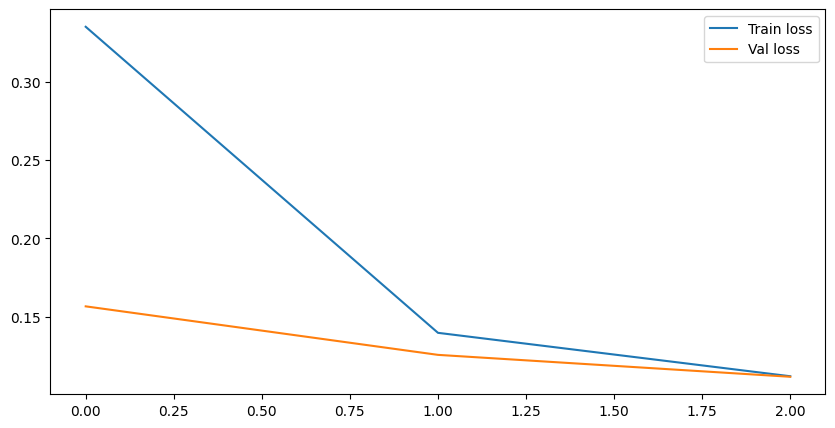

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

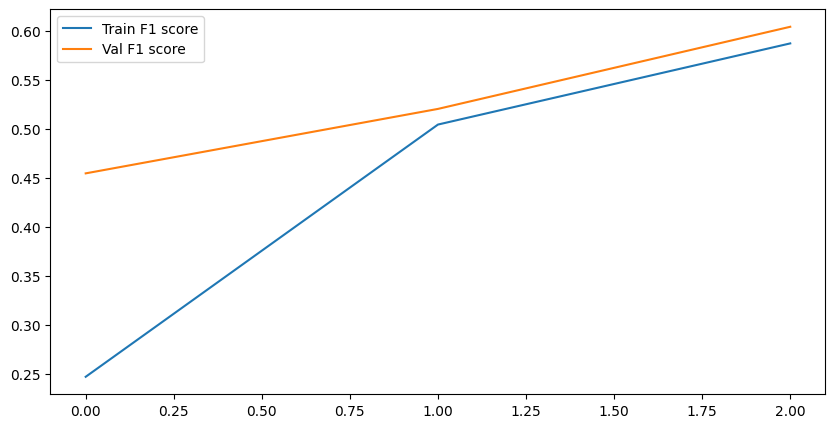

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

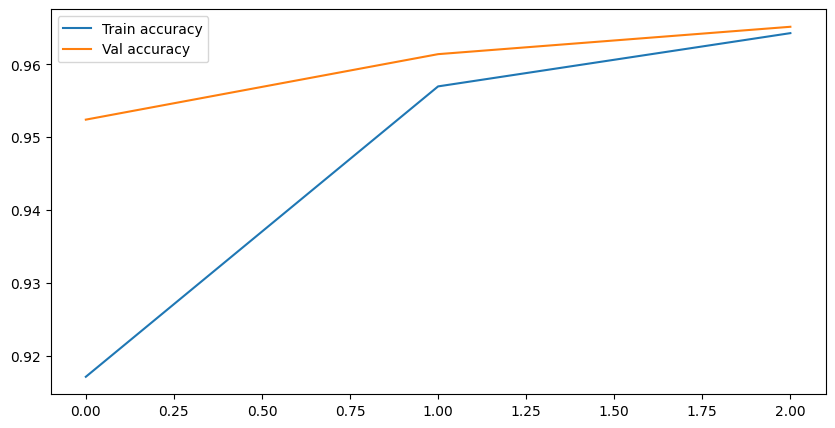

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [42]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [43]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_gru_word2vec.pt")

Epoch 1
Train loss: 0.23439544041951496, Val loss: 0.10175670236349106
Train accuracy: 0.9067187411558273, Val accuracy: 0.9736089885096507
Train F1: 0.3268454669978961, Val F1: 0.328876014846575
Epoch 2
Train loss: 0.08705323735872904, Val loss: 0.07385246977210044
Train accuracy: 0.9736089885096507, Val accuracy: 0.9736089885096507
Train F1: 0.328876014846575, Val F1: 0.328876014846575
Epoch 3
Train loss: 0.06840293208758036, Val loss: 0.06234418253103892
Train accuracy: 0.9750099054734817, Val accuracy: 0.9766089319069452
Train F1: 0.41658109130902643, Val F1: 0.45716833086680025


In [44]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9766089319069452 Test F1: 0.45716833086680025


### Plots

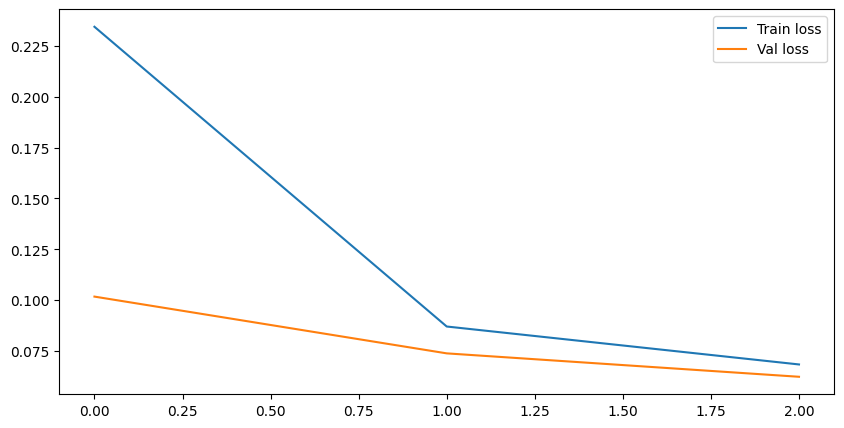

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

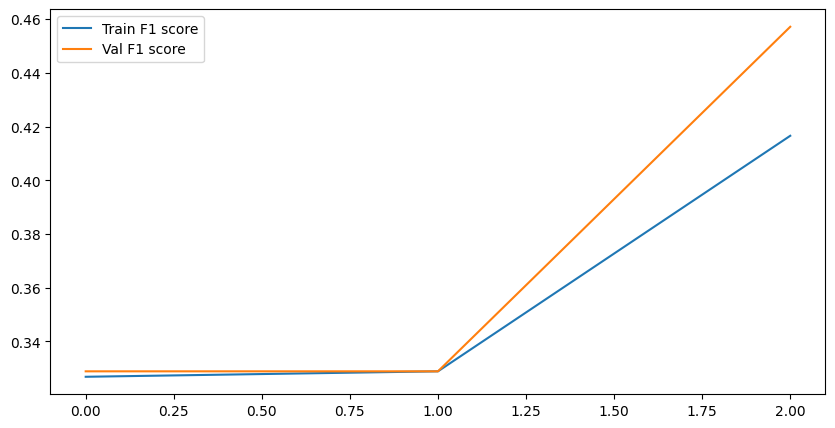

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

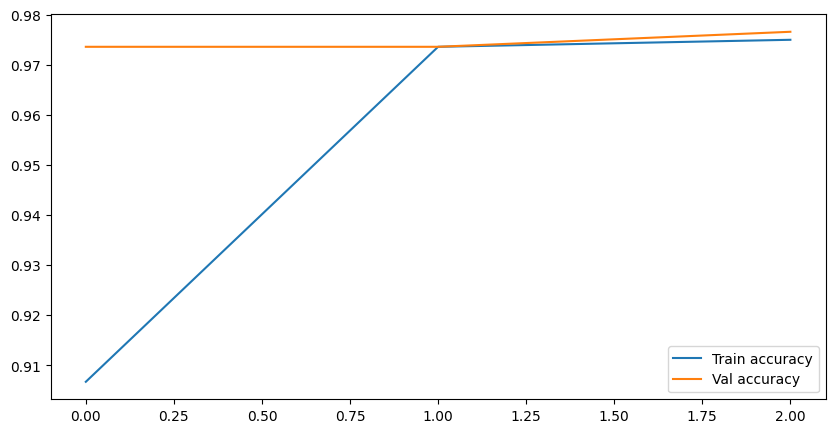

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## GloVe Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [48]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [49]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [50]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [51]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_gru_glove.pt")

Epoch 1
Train loss: 0.3635280096961051, Val loss: 0.22817164133576787
Train accuracy: 0.9206587828716454, Val accuracy: 0.9345990783410139
Train F1: 0.21037343532512448, Val F1: 0.3255766561619339
Epoch 2
Train loss: 0.20559288822498517, Val loss: 0.20196723499718836
Train accuracy: 0.939391975808629, Val accuracy: 0.9399201228878649
Train F1: 0.3679136373186692, Val F1: 0.39364056090427463
Epoch 3
Train loss: 0.17827850395871192, Val loss: 0.1891588533625883
Train accuracy: 0.9454160591824613, Val accuracy: 0.9429554531490015
Train F1: 0.46982627846336594, Val F1: 0.4678069448682721


In [52]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9421180555555555 Test F1: 0.47365396154131517


### Plots

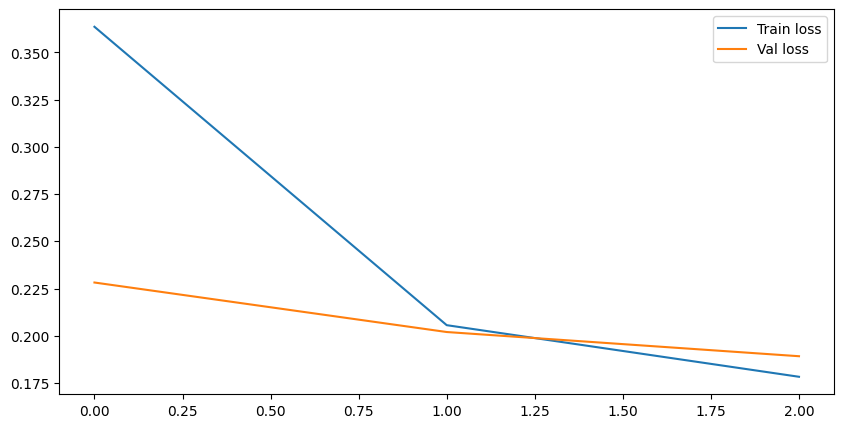

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

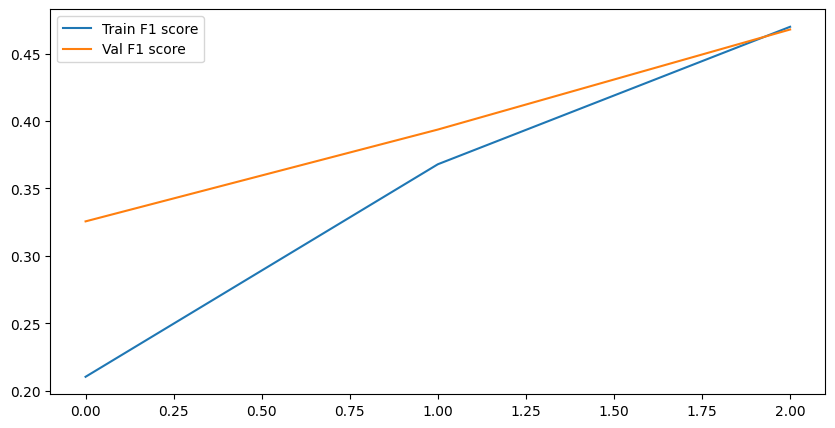

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

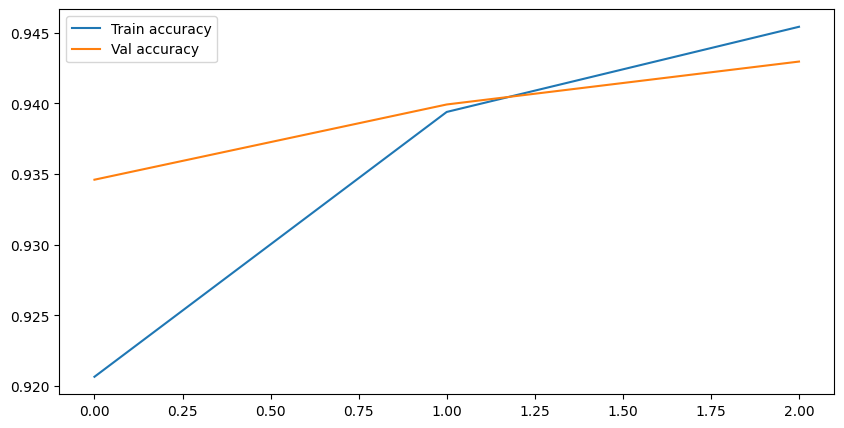

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training

In [56]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [57]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_gru_glove.pt")

Epoch 1
Train loss: 0.22992493013540904, Val loss: 0.08879921386639276
Train accuracy: 0.9051338653987661, Val accuracy: 0.9695760457349861
Train F1: 0.34160139952357677, Val F1: 0.45865668844650553
Epoch 2
Train loss: 0.07506704851984977, Val loss: 0.062643085171779
Train accuracy: 0.974599535857814, Val accuracy: 0.9782362596932134
Train F1: 0.44241531648610316, Val F1: 0.4885396482266391
Epoch 3
Train loss: 0.05613130331039429, Val loss: 0.05220926528175672
Train accuracy: 0.9798777381558839, Val accuracy: 0.9818871342050149
Train F1: 0.6389480260584071, Val F1: 0.7004599722144015


In [58]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9818871342050149 Test F1: 0.7004599722144015


### Plots

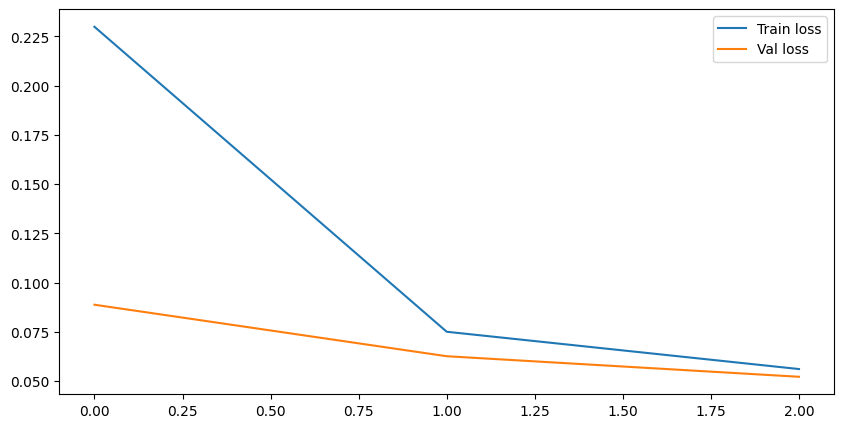

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

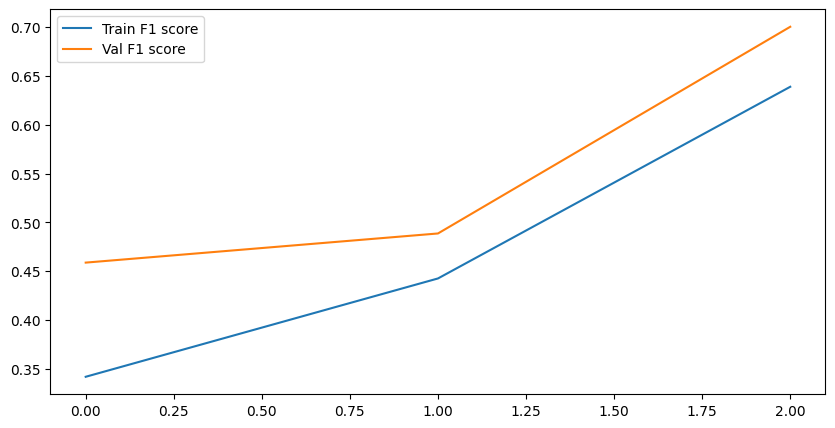

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

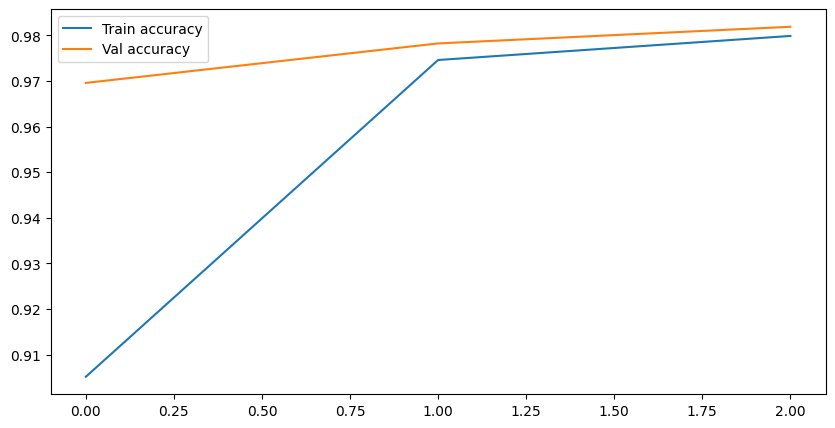

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## Fasttext Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [62]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [63]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [64]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [65]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t1_gru_fasttext.pt")

Epoch 1
Train loss: 0.41137240642739326, Val loss: 0.2823711440843694
Train accuracy: 0.9064377126194719, Val accuracy: 0.922384024577573
Train F1: 0.1164147125628926, Val F1: 0.15388640085212651
Epoch 2
Train loss: 0.24547288712766982, Val loss: 0.22968994081020355
Train accuracy: 0.9305794049354716, Val accuracy: 0.9332718894009217
Train F1: 0.2684196681940328, Val F1: 0.30691297996698463
Epoch 3
Train loss: 0.2129255244412373, Val loss: 0.22264636176473954
Train accuracy: 0.9355839948161347, Val accuracy: 0.9345867895545314
Train F1: 0.34326335004614583, Val F1: 0.32664750631229006


In [66]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9338715277777778 Test F1: 0.3476955192007191


### Plots

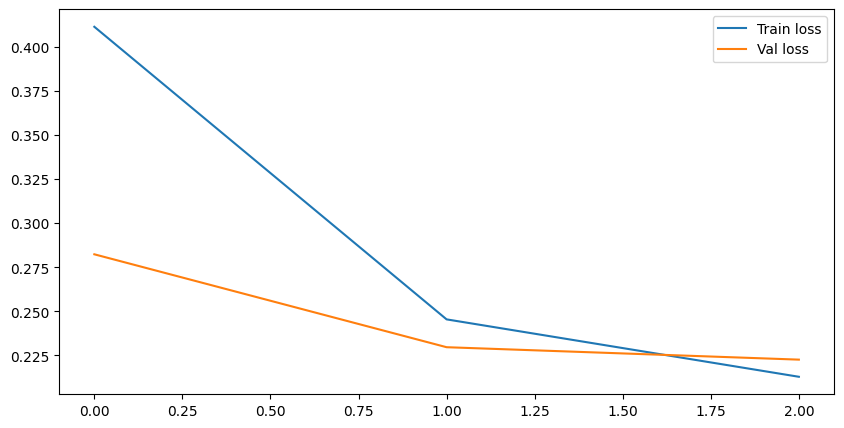

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

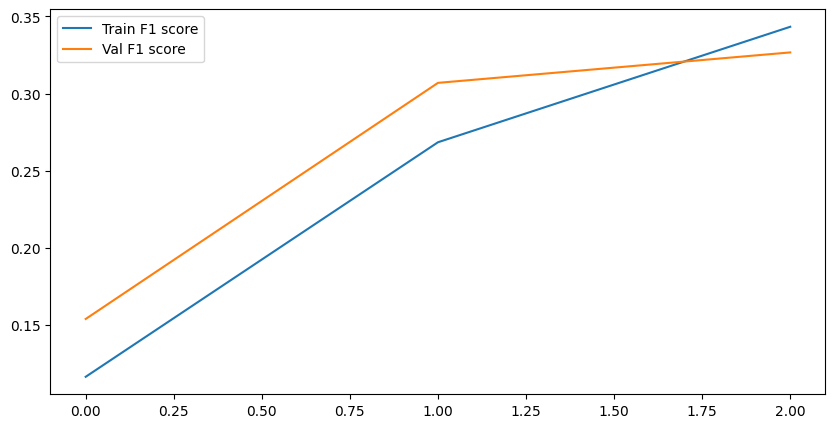

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

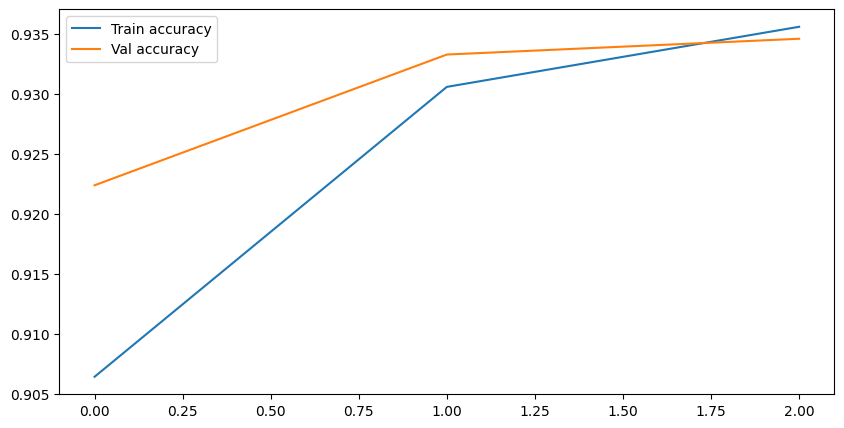

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [70]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 512, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [71]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=3)
torch.save(model, "../trained_models/t2_gru_fasttext.pt")

Epoch 1
Train loss: 0.2408114453156789, Val loss: 0.08228897005319595
Train accuracy: 0.9048791532235241, Val accuracy: 0.9736089885096507
Train F1: 0.3202149981093764, Val F1: 0.3293975198023666
Epoch 2
Train loss: 0.0757568451265494, Val loss: 0.06957450260718663
Train accuracy: 0.9748117960038489, Val accuracy: 0.9769626988170035
Train F1: 0.41030260011686726, Val F1: 0.44961156434199984
Epoch 3
Train loss: 0.06082994018991788, Val loss: 0.05166349361340205
Train accuracy: 0.9795098205694233, Val accuracy: 0.9831606950812248
Train F1: 0.6052033697952881, Val F1: 0.7270208807439723


In [72]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9831606950812248 Test F1: 0.7270208807439723


### Plots

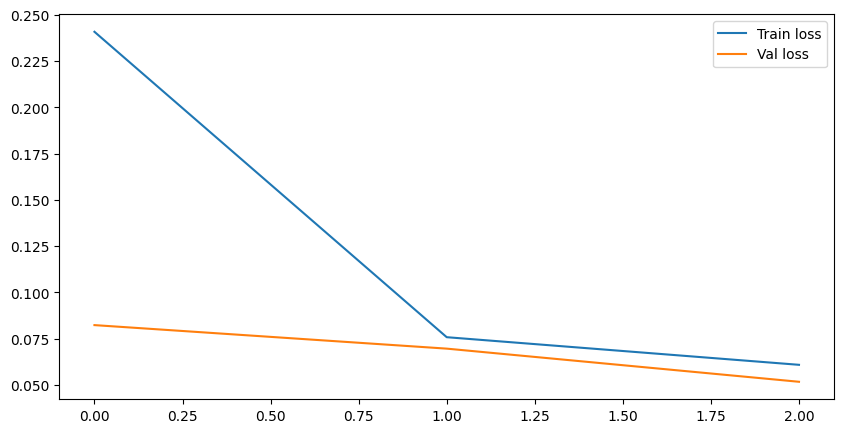

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

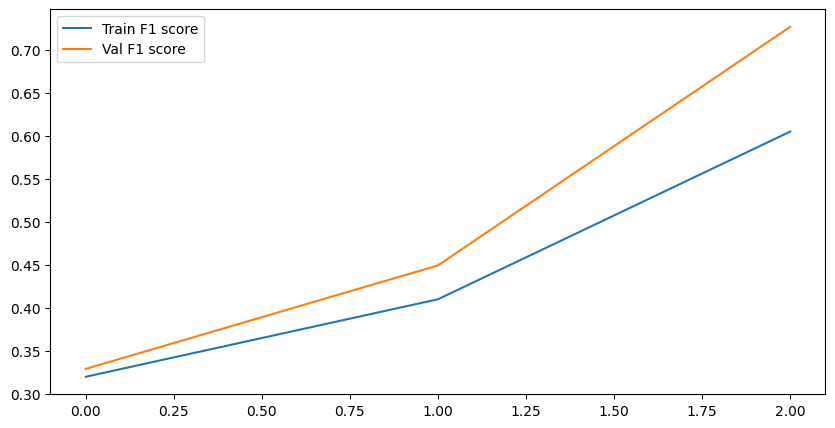

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

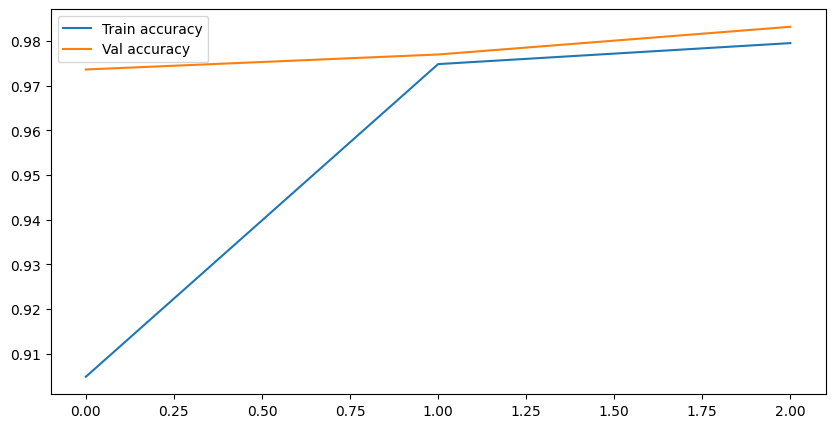

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()